Historical weather data from Basel is used to predict the amount of *Short wave radiation* on a hourly basis. The data covers 1863 days from 07/2013 to 07/2018. The model is tested on data from 07/2012 to 07/2013.


The input variables used were,

* Hour of day (0-24)
* Temperature (2m above ground)
* Relative Humidity (2m above ground)


This notebook walksthrough the data processing and modelling done for this task. Data can be found [here](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2013-07-19+to+2018-07-18&params=&params%5B%5D=11%3B2+m+above+gnd&params%5B%5D=52%3B2+m+above+gnd&params%5B%5D=71%3Bsfc&params%5B%5D=204%3Bsfc&utc_offset=2&aggregation=hourly&temperatureunit=CELSIUS&windspeedunit=KILOMETER_PER_HOUR).

In [6]:
# -*- coding: utf-8 -*-
from numpy.random import seed
seed(42)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

For building the model I use the keras scikit-learn API. While this API constrains us to single input models, it does feel familiar to anyone already acustomed to this interface and provides all the expected functionality.


I am using the tensorflow backend for keras (this is also the default setting) and have not used GPU accelaration for this model. This code will work regardless if anyone does run it on any other backend.


**Note** keras version 2.1.4 was used

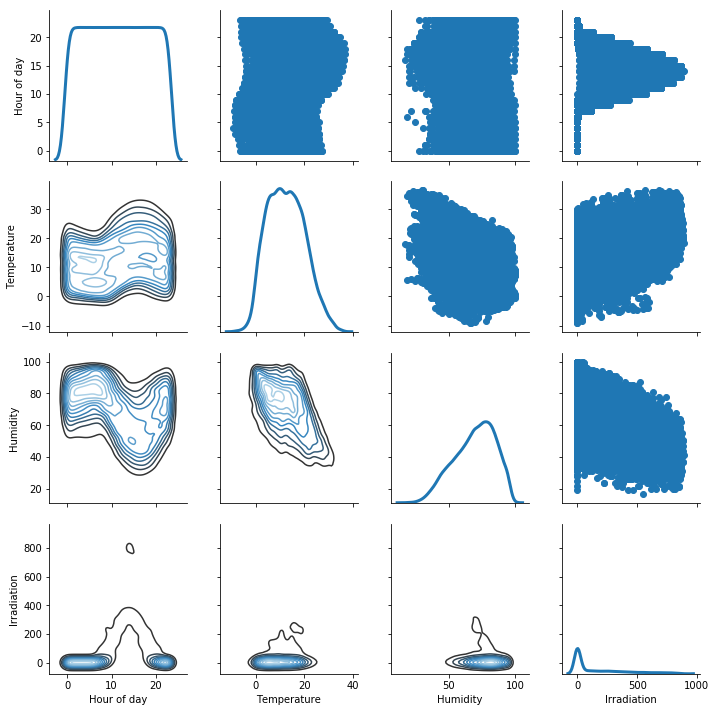

In [8]:
# Import data

data = pd.read_csv("./history_export_2018-07-19T13_39_29.csv", header=None).astype(float)
data.drop([0,1,2,4,7], axis=1, inplace=True)
data.rename({3: 'Hour of day', 5: 'Temperature', 6: 'Humidity', 8: 'Irradiation'}, axis = 'columns', inplace=True)

grid = sns.PairGrid(data)
grid = grid.map_upper(plt.scatter)
grid = grid.map_lower(sns.kdeplot, cmap="Blues_d")
grid = grid.map_diag(sns.kdeplot, lw=3, legend=False)
plt.show()

The grid plot shows us the distribution of each variable on the diagonal. Above the diagonal are the pair-wise scatterplots. Below the diagonal are the pairwise density plots.


From the grid plot is is quite evident that the data in its current form cannot be used to model the relationship between Hour, Temparature and Humidity with Irradiation in any meaningful way. 


**This is because the predicitve variables are not correlated with Irradiation at all!**

It is interesting to see that for the variable *Hour of day*, Irradiation is zero at early and later hours probably corresponding to the daylight cycle. As it turns out, short wave radiation only occurs during daylight hours so we can safely remove the rows corresponding to darkness.


**This is okay, since the during darkness Irradiation is always zero, thus the relationship is trivial (and known) therefore we can focus the modelling effort on the daylight hours only!**

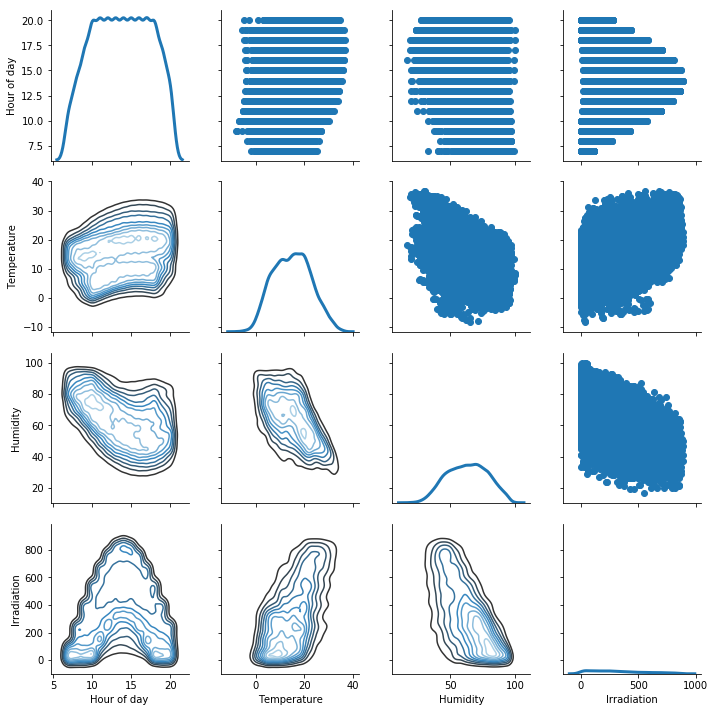

In [14]:
# Dropping zero values irradiation

data = data.loc[~data['Hour of day'].isin([0,1,2,3,4,5,6,21,22,23])]
data = data.apply(lambda x: x.replace(0.0, np.nan)).dropna(how='any', axis=0)

grid = sns.PairGrid(data)
grid = grid.map_upper(plt.scatter)
grid = grid.map_lower(sns.kdeplot, cmap="Blues_d")
grid = grid.map_diag(sns.kdeplot, lw=3, legend=False)
plt.show()

**After dropping all rows with Irradiation value of zero, we can see that the predictive variables can now be used to predict Irradiation during daylight hours.**

It is also obvious that methods assuming that the data is distributed normally are not applicable in this case. This is not a problem with the neural network model which doesn't have such assumptions. It will also handle non-linear interactions but the challenge for us is to prevent overfitting!

**We will use a custom metric function to monitor our model that is based on the pearson correlation. Ultimately, we only care about modelling the relationship between the predictive variables and Irradiation. The absolute values can be obtained easily as long as the output is linearly associated with the real values.**

In [15]:
# Custom metric function

def correlation_coefficient_metric(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(np.multiply(xm,ym))
    r_den = K.sqrt(np.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return r

**We will split the data into validation and training sets in a 9:1 ratio.**

In [27]:
# Split into input (X) and output (Y) variables

X = data.iloc[:,0:3]
Y = data.iloc[:,3]

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.10, shuffle=True, random_state=0)

**Finally we set up and train the model.** 

The values for number of iterations, optimizer, loss and metric are ones that worked best for me. There are many more options that could be tested to improve the model. The scikit-learn API allows easy usage of the grid search function and can be a great tool to use here as the data is not that big or complex.


In [18]:
# Choose values that are suitable

num_epochs  = 1000
opt = Adam()
loss_f = 'mse'
metric = correlation_coefficient_metric

# Create model

model = Sequential()

model.add(Dense(27, input_dim=3, activation='relu', bias_initializer = 'RandomNormal'))
model.add(Dense(27, activation='relu'))
model.add(Dense(9, activation='relu'))

model.add(Dense(1, activation = 'relu'))

# Compile model

model.compile(loss=loss_f, optimizer= opt, metrics = [metric])

# Train the model

hist = model.fit(x_train ,y_train, batch_size = 200, epochs=num_epochs, shuffle=True)

# Plotting loss

train_loss=hist.history['loss']

Epoch 1/1000
19926/19926 [==============================] - 0s 8us/step - loss: 149132.7678 - correlation_coefficient_metric: -0.6353
Epoch 2/1000
19926/19926 [==============================] - 0s 4us/step - loss: 90565.9844 - correlation_coefficient_metric: -0.5497
Epoch 3/1000
19926/19926 [==============================] - 0s 4us/step - loss: 58575.5472 - correlation_coefficient_metric: -0.1988
Epoch 4/1000
19926/19926 [==============================] - 0s 4us/step - loss: 48373.2241 - correlation_coefficient_metric: 0.3173
Epoch 5/1000
19926/19926 [==============================] - 0s 4us/step - loss: 40425.2656 - correlation_coefficient_metric: 0.5035
Epoch 6/1000
19926/19926 [==============================] - 0s 4us/step - loss: 37784.3032 - correlation_coefficient_metric: 0.5477
Epoch 7/1000
19926/19926 [==============================] - 0s 4us/step - loss: 37241.7985 - correlation_coefficient_metric: 0.5602
Epoch 8/1000
19926/19926 [==============================] - 0s 4us/step 

19926/19926 [==============================] - 0s 4us/step - loss: 20335.4112 - correlation_coefficient_metric: 0.7911
Epoch 63/1000
19926/19926 [==============================] - 0s 4us/step - loss: 19779.9297 - correlation_coefficient_metric: 0.7993
Epoch 64/1000
19926/19926 [==============================] - 0s 4us/step - loss: 19197.7838 - correlation_coefficient_metric: 0.8042
Epoch 65/1000
19926/19926 [==============================] - 0s 4us/step - loss: 18694.7522 - correlation_coefficient_metric: 0.8100
Epoch 66/1000
19926/19926 [==============================] - 0s 4us/step - loss: 18172.5700 - correlation_coefficient_metric: 0.8150
Epoch 67/1000
19926/19926 [==============================] - 0s 4us/step - loss: 17796.4598 - correlation_coefficient_metric: 0.8190
Epoch 68/1000
19926/19926 [==============================] - 0s 4us/step - loss: 17552.9001 - correlation_coefficient_metric: 0.8228
Epoch 69/1000
19926/19926 [==============================] - 0s 4us/step - loss: 17

19926/19926 [==============================] - 0s 4us/step - loss: 14557.4076 - correlation_coefficient_metric: 0.8541
Epoch 124/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14681.7514 - correlation_coefficient_metric: 0.8541
Epoch 125/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14611.7985 - correlation_coefficient_metric: 0.8545
Epoch 126/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14630.3979 - correlation_coefficient_metric: 0.8546
Epoch 127/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14575.2365 - correlation_coefficient_metric: 0.8543
Epoch 128/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14607.2704 - correlation_coefficient_metric: 0.8549
Epoch 129/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14575.6856 - correlation_coefficient_metric: 0.8550
Epoch 130/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 14006.5259 - correlation_coefficient_metric: 0.8601
Epoch 185/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14058.9577 - correlation_coefficient_metric: 0.8597
Epoch 186/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14020.9818 - correlation_coefficient_metric: 0.8603
Epoch 187/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14143.0770 - correlation_coefficient_metric: 0.8593
Epoch 188/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14032.6180 - correlation_coefficient_metric: 0.8604
Epoch 189/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14122.9796 - correlation_coefficient_metric: 0.8605
Epoch 190/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14061.1270 - correlation_coefficient_metric: 0.8593
Epoch 191/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13760.2410 - correlation_coefficient_metric: 0.8629
Epoch 246/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13895.7903 - correlation_coefficient_metric: 0.8622
Epoch 247/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14001.0431 - correlation_coefficient_metric: 0.8624
Epoch 248/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13810.1473 - correlation_coefficient_metric: 0.8631
Epoch 249/1000
19926/19926 [==============================] - 0s 4us/step - loss: 14047.0805 - correlation_coefficient_metric: 0.8620
Epoch 250/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13890.0427 - correlation_coefficient_metric: 0.8625
Epoch 251/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13744.2020 - correlation_coefficient_metric: 0.8629
Epoch 252/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13719.5283 - correlation_coefficient_metric: 0.8638
Epoch 307/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13703.4419 - correlation_coefficient_metric: 0.8642
Epoch 308/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13664.4262 - correlation_coefficient_metric: 0.8637
Epoch 309/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13689.7540 - correlation_coefficient_metric: 0.8645
Epoch 310/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13730.2267 - correlation_coefficient_metric: 0.8643
Epoch 311/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13776.6088 - correlation_coefficient_metric: 0.8641
Epoch 312/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13680.9975 - correlation_coefficient_metric: 0.8643
Epoch 313/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13553.4854 - correlation_coefficient_metric: 0.8656
Epoch 368/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13560.3852 - correlation_coefficient_metric: 0.8651
Epoch 369/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13568.1247 - correlation_coefficient_metric: 0.8652
Epoch 370/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13650.3435 - correlation_coefficient_metric: 0.8649
Epoch 371/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13548.7385 - correlation_coefficient_metric: 0.8658
Epoch 372/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13493.4603 - correlation_coefficient_metric: 0.8655
Epoch 373/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13717.0757 - correlation_coefficient_metric: 0.8647
Epoch 374/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 5us/step - loss: 13498.8851 - correlation_coefficient_metric: 0.8659
Epoch 429/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13479.0334 - correlation_coefficient_metric: 0.8664
Epoch 430/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13464.0253 - correlation_coefficient_metric: 0.8656
Epoch 431/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13440.6178 - correlation_coefficient_metric: 0.8662
Epoch 432/1000
19926/19926 [==============================] - 0s 5us/step - loss: 13532.2271 - correlation_coefficient_metric: 0.8657
Epoch 433/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13494.2073 - correlation_coefficient_metric: 0.8659
Epoch 434/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13636.8053 - correlation_coefficient_metric: 0.8661
Epoch 435/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13361.0480 - correlation_coefficient_metric: 0.8674
Epoch 490/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13574.1185 - correlation_coefficient_metric: 0.8661
Epoch 491/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13397.6532 - correlation_coefficient_metric: 0.8671
Epoch 492/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13374.3822 - correlation_coefficient_metric: 0.8671
Epoch 493/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13533.9569 - correlation_coefficient_metric: 0.8670
Epoch 494/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13476.6083 - correlation_coefficient_metric: 0.8671
Epoch 495/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13415.7591 - correlation_coefficient_metric: 0.8667
Epoch 496/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13346.8933 - correlation_coefficient_metric: 0.8674
Epoch 551/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13395.4065 - correlation_coefficient_metric: 0.8671
Epoch 552/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13463.3646 - correlation_coefficient_metric: 0.8677
Epoch 553/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13367.0853 - correlation_coefficient_metric: 0.8673
Epoch 554/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13401.7390 - correlation_coefficient_metric: 0.8676
Epoch 555/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13361.4771 - correlation_coefficient_metric: 0.8669
Epoch 556/1000
19926/19926 [==============================] - 0s 5us/step - loss: 13401.8331 - correlation_coefficient_metric: 0.8675
Epoch 557/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13323.2335 - correlation_coefficient_metric: 0.8677
Epoch 612/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13342.6435 - correlation_coefficient_metric: 0.8677
Epoch 613/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13366.7370 - correlation_coefficient_metric: 0.8675
Epoch 614/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13303.5535 - correlation_coefficient_metric: 0.8678
Epoch 615/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13459.3918 - correlation_coefficient_metric: 0.8671
Epoch 616/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13321.6517 - correlation_coefficient_metric: 0.8677
Epoch 617/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13308.4216 - correlation_coefficient_metric: 0.8676
Epoch 618/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13278.1277 - correlation_coefficient_metric: 0.8677
Epoch 673/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13330.4245 - correlation_coefficient_metric: 0.8681
Epoch 674/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13461.4785 - correlation_coefficient_metric: 0.8675
Epoch 675/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13338.9467 - correlation_coefficient_metric: 0.8678
Epoch 676/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13311.4664 - correlation_coefficient_metric: 0.8682
Epoch 677/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13269.2862 - correlation_coefficient_metric: 0.8681
Epoch 678/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13381.0201 - correlation_coefficient_metric: 0.8681
Epoch 679/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13256.5328 - correlation_coefficient_metric: 0.8680
Epoch 734/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13280.7316 - correlation_coefficient_metric: 0.8685
Epoch 735/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13352.6549 - correlation_coefficient_metric: 0.8682
Epoch 736/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13272.1800 - correlation_coefficient_metric: 0.8679
Epoch 737/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13266.9478 - correlation_coefficient_metric: 0.8685
Epoch 738/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13310.3061 - correlation_coefficient_metric: 0.8681
Epoch 739/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13272.6257 - correlation_coefficient_metric: 0.8684
Epoch 740/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13254.9420 - correlation_coefficient_metric: 0.8683
Epoch 795/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13226.8125 - correlation_coefficient_metric: 0.8682
Epoch 796/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13387.6684 - correlation_coefficient_metric: 0.8686
Epoch 797/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13209.2071 - correlation_coefficient_metric: 0.8682
Epoch 798/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13286.9913 - correlation_coefficient_metric: 0.8684
Epoch 799/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13193.7212 - correlation_coefficient_metric: 0.8687
Epoch 800/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13323.9691 - correlation_coefficient_metric: 0.8685
Epoch 801/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13207.3649 - correlation_coefficient_metric: 0.8696
Epoch 856/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13348.2050 - correlation_coefficient_metric: 0.8690
Epoch 857/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13308.7618 - correlation_coefficient_metric: 0.8691
Epoch 858/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13176.1742 - correlation_coefficient_metric: 0.8694
Epoch 859/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13253.2395 - correlation_coefficient_metric: 0.8692
Epoch 860/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13173.9534 - correlation_coefficient_metric: 0.8691
Epoch 861/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13217.1588 - correlation_coefficient_metric: 0.8697
Epoch 862/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13176.3251 - correlation_coefficient_metric: 0.8698
Epoch 917/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13099.7716 - correlation_coefficient_metric: 0.8699
Epoch 918/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13158.7060 - correlation_coefficient_metric: 0.8696
Epoch 919/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13275.3698 - correlation_coefficient_metric: 0.8692
Epoch 920/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13134.4622 - correlation_coefficient_metric: 0.8690
Epoch 921/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13105.4690 - correlation_coefficient_metric: 0.8702
Epoch 922/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13128.5139 - correlation_coefficient_metric: 0.8696
Epoch 923/1000
19926/19926 [==============================] - 0s 4us/step - l

19926/19926 [==============================] - 0s 4us/step - loss: 13146.5607 - correlation_coefficient_metric: 0.8696
Epoch 978/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13123.9664 - correlation_coefficient_metric: 0.8698
Epoch 979/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13103.6217 - correlation_coefficient_metric: 0.8702
Epoch 980/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13163.2968 - correlation_coefficient_metric: 0.8702
Epoch 981/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13096.9078 - correlation_coefficient_metric: 0.8705
Epoch 982/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13119.5853 - correlation_coefficient_metric: 0.8698
Epoch 983/1000
19926/19926 [==============================] - 0s 4us/step - loss: 13093.4568 - correlation_coefficient_metric: 0.8702
Epoch 984/1000
19926/19926 [==============================] - 0s 4us/step - l

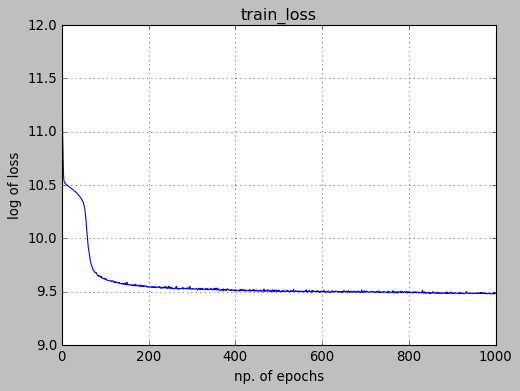

In [25]:
plt.figure(1, figsize=(7,5))
plt.plot(range(num_epochs), np.log(train_loss))
plt.xlabel('np. of epochs')
plt.ylabel('log of loss')
plt.title('train_loss')
plt.grid(True)
plt.show()

**The plot shows us that the loss goes down quite rapidly upto the 200th epoch and starts to stabilise afterwards.** 

The choice of optimiser has a very strong effect on the rate of learning. Here we used the Adam optimiser with no decay in the learning rate.

In [30]:
# Validation

score = model.evaluate(x_val, y_val)

print('Correlation between actual and predicted values for validation data: %s \n' % score[1])

2214/2214 [==============================] - 0s 11us/step
Correlation between actual and predicted values for validation data: 0.8667107491527685 



**We get a very good correlation value between the actual and predicted Irradiation.**

The validation data was selected randomly from the testing data and therefore contains samples from different years and hour of day. This is a good sign that our model works!

However it is better to test the model on a different dataset. **The test data used here comes from the timeframe 07/2012-07/2013 and thus does not have any samples from the years we trained the model on.**

4424/4424 [==============================] - 0s 10us/step
Correlation between actual and predicted values for testing data: 0.8667107491527685 



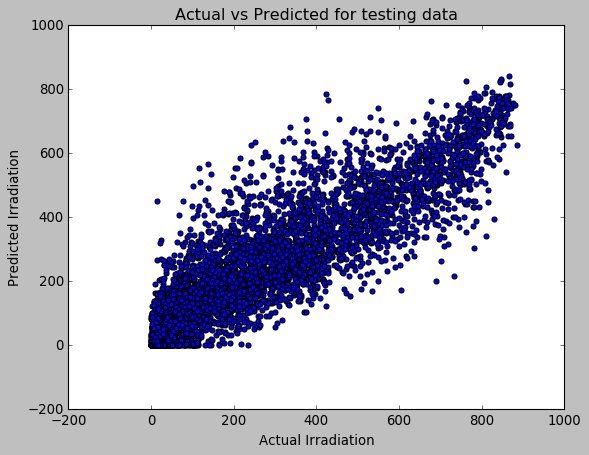

In [33]:
# Testing

tdata = pd.read_csv("./history_export_2018-07-19T17_56_33.csv", header=None).astype(float)
tdata.drop([0,1,2,4,7], axis=1, inplace=True)
tdata.rename({3: 'Hour of day', 5: 'Temperature', 6: 'Humidity', 8: 'Irradiation'}, axis = 'columns', inplace=True)
tdata = tdata.loc[~tdata['Hour of day'].isin([0,1,2,3,4,5,6,21,22,23])]
tdata = tdata.apply(lambda x: x.replace(0.0, np.nan)).dropna(how='any', axis=0)

X_test = tdata.iloc[:,0:3]
Y_test = tdata.iloc[:,3]

predictions = model.predict(X_test)

tscore = model.evaluate(X_test, Y_test)

print('Correlation between actual and predicted values for testing data: %s \n' % score[1])

plt.scatter(Y_test, predictions)
plt.xlabel('Actual Irradiation')
plt.ylabel('Predicted Irradiation')
plt.title('Actual vs Predi')
plt.show()

**We again get a good correlation value between the actual and predicted Irradiation for the test set.**

From the plot, we can see that the predicted and actual values have a linear dependance but for some values the predictions can be quite wrong!

One adjustment that can be made is to regress the predicted values on the original values and adjust the predicted values to obtain scaled predictions that belong to the distribution of the actual data. This is not particularly useful in the testing dataset and makes predcitions worse in certain cases.

Though for the validation set, this was quite useful!

Slope and intercept of the regression model between predicted and actual Irradiation:  1.0000000165916325 -2.3622289972990984e-06


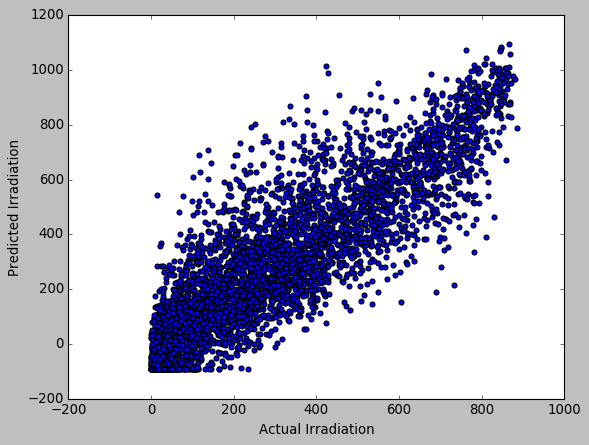

In [39]:
slope, intercept = stats.linregress(Y_test.values.reshape((len(Y_test),)), predictions.reshape((len(Y_test),)))[0:2]

print("Slope and intercept of the regression model between predicted and actual Irradiation: ", slope, intercept)

predictions = (predictions-intercept)/slope

plt.scatter(Y_test, predictions)
plt.xlabel('Actual Irradiation')
plt.ylabel('Predicted Irradiation')
plt.show()

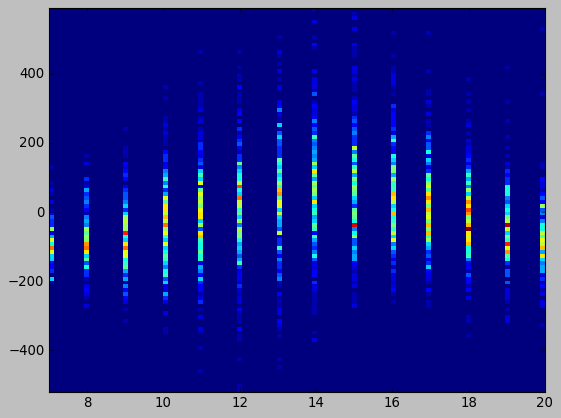

In [65]:
residuals = predictions.reshape((len(Y_test),)) - Y_test.values.reshape((len(Y_test),))
hours = X_test.values[:,0]

plt.hist2d(hours, residuals, bins=100)
plt.show()

**Errors are distributed over all hours.**

The intention was to find out if the predictions are worse for any particular hour of the day which could have then been dropped. However, this does not seem to be the case.

(array([   6.,   34.,  226., 1059., 1516., 1028.,  372.,  122.,   43.,
          18.]),
 array([-519.32594238, -408.21849463, -297.11104687, -186.00359912,
         -74.89615137,   36.21129639,  147.31874414,  258.42619189,
         369.53363965,  480.6410874 ,  591.74853516]),
 <a list of 10 Patch objects>)

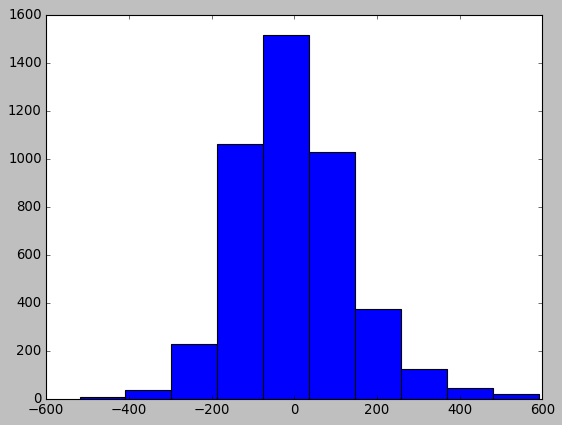

In [66]:
plt.hist(residuals)

In [ ]:
#Save the trained model

#model.save('Trained.h5')